## Library

In [534]:
import math
import random
import numpy as np
from copy import copy
from scipy import stats
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

exec(open('library.py').read())
print('Loaded')

Loaded
Loaded


## Variables (customize these)

In [550]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 1000                                       # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)


# This is a PDF for when TAI will be available to be developed. Look to `When TAI?` notebook to generate this.
tai_pdf = [0.003, 0.004, 0.003, 0.004, 0.007, 0.008, 0.015, 0.014, 0.016,
       0.013, 0.017, 0.02 , 0.018, 0.022, 0.021, 0.032, 0.021, 0.017,
       0.025, 0.021, 0.017, 0.025, 0.022, 0.028, 0.012, 0.028, 0.013,
       0.021, 0.011, 0.017, 0.029, 0.025, 0.012, 0.016, 0.009, 0.014,
       0.011, 0.012, 0.009, 0.011, 0.013, 0.01 , 0.009, 0.012, 0.008,
       0.01 , 0.012, 0.006, 0.004, 0.002, 0.004, 0.006, 0.005, 0.007,
       0.005, 0.007, 0.004, 0.004, 0.005, 0.002, 0.002, 0.001, 0.009,
       0.009, 0.002, 0.004, 0.003, 0.002, 0.002, 0.   , 0.004, 0.003,
       0.003, 0.004, 0.003, 0.005, 0.004, 0.   , 0.003, 0.004, 0.   ,
       0.001, 0.001, 0.002, 0.001, 0.   , 0.001, 0.002, 0.002, 0.003,
       0.002, 0.002, 0.001, 0.   , 0.   , 0.001, 0.005, 0.001, 0.001,
       0.002, 0.   , 0.001, 0.   , 0.002, 0.001, 0.   , 0.001, 0.003,
       0.001, 0.   , 0.001, 0.002, 0.   , 0.001, 0.   , 0.   , 0.001,
       0.002, 0.   , 0.   , 0.001, 0.002, 0.   , 0.002, 0.   , 0.001,
       0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.001, 0.   , 0.   ,
       0.002, 0.001, 0.   , 0.   , 0.001, 0.   , 0.001, 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.001, 0.001, 0.002, 0.   , 0.   , 0.   ,
       0.   , 0.001, 0.   , 0.001, 0.001, 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.002,
       0.001, 0.   , 0.   , 0.   , 0.001, 0.001, 0.   , 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.001, 0, 0]
tai_pdf = np.array(tai_pdf)


# Make the chance TAI alignment is solved be a function of year
# This version starts at 30% and rises to 75% over time
# 30% can be best interpreted here as the likelihood that AI is "safe by default"
def p_chance_alignment_solved(year):
    return min(0.3 + 0.3*((year-2022)/100), 0.75)

# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making an unaligned agentic TAI, will it produce an xrisk?
p_unaligned_tai_is_xrisk = 0.9 * 0.4 * 0.98

# Conditional on having TAI available, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.1

# What is the chance in a given year there will be a great power war?
def p_great_power_war(year):
    if year < 2025:
        return 0.006
    elif year < 2030:
        return 0.006 + 0.3*0.05*0.2
    elif year < 2040:
        return 0.006 + 0.002 + 0.05*0.05*0.2
    else:
        return (0.006 + 0.05*0.05*0.2) * (0.99 ** (year - CURRENT_YEAR))

# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war):
    return 0.06 if war else 0.02   # TODO: reduce with time

# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
p_nuclear_accident_becomes_exchange = 0.09 # TODO: higher in great power war

# Conditional on a nuclear exchange, what is the chance it escalates into a xrisk?
p_xrisk_from_nuclear_exchange = 0.4 * 0.8 * 0.2 * 0.2  # TODO: higher in great power war, maybe also change arsenal size over time?

# Conditional on a great power war, what is the chance it goes nuclear in any given year?
p_nuclear_war_given_war = 0.05

# Conditional on a great power war, what is the chance it results in a bioweapon?
p_biowar_given_war = 0.005

# Conditional on a bioweapon, what is the chance it escalates into a xrisk?
p_xrisk_from_bio = 0.2 * 0.2

# Wha is the chance in a given year that nanotech will be developed?
p_nanotech_possible = 0.001 # TODO: increase based on year

# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.2

# What is the chance in any given year that an unknown unknown xrisk occurs?
p_unknown_unknown_xrisk = 0.001 # TODO: increase based on year
    

# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
print('Loaded')

Loaded


## TAI Timelines

Text(0, 0.5, 'chance of TAI IN year')

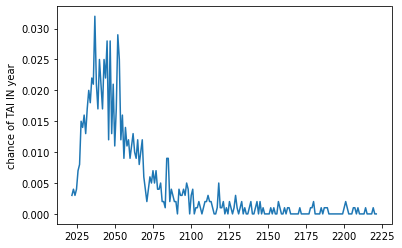

In [551]:
plt.plot(years, tai_pdf)
plt.ylabel('chance of TAI IN year')


Text(0, 0.5, 'chance of TAI BY year')

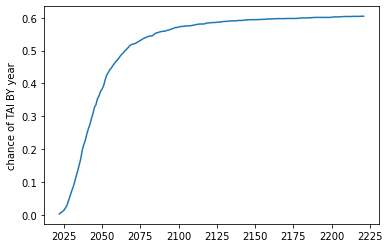

In [552]:
tai_cdf = np.cumsum([tai_pdf[0] if x == 0 else tai_pdf[x] * np.prod(1 - tai_pdf[:x]) for x in range(MAX_YEAR - CURRENT_YEAR)])
plt.plot(years, tai_cdf)
plt.ylabel('chance of TAI BY year')

# TODO: Fix


## Chance of Solving Alignment by Year (Conditional on TAI in that year)

Text(0, 0.5, 'chance of solving TAI alignment')

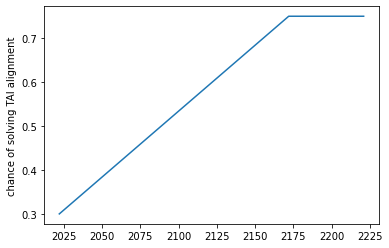

In [536]:
alignment_p = np.array([p_chance_alignment_solved(y) for y in years])
plt.plot(years, alignment_p)
plt.ylabel('chance of solving alignment if TAI in year')


In [537]:
for y in years:
    print('Year: {} - chance of solving TAI alignment {}%'.format(y,
                                                                  np.round(alignment_p[y - CURRENT_YEAR] * 100, 0)))

Year: 2022 - chance of solving TAI alignment 30.0%
Year: 2023 - chance of solving TAI alignment 30.0%
Year: 2024 - chance of solving TAI alignment 31.0%
Year: 2025 - chance of solving TAI alignment 31.0%
Year: 2026 - chance of solving TAI alignment 31.0%
Year: 2027 - chance of solving TAI alignment 32.0%
Year: 2028 - chance of solving TAI alignment 32.0%
Year: 2029 - chance of solving TAI alignment 32.0%
Year: 2030 - chance of solving TAI alignment 32.0%
Year: 2031 - chance of solving TAI alignment 33.0%
Year: 2032 - chance of solving TAI alignment 33.0%
Year: 2033 - chance of solving TAI alignment 33.0%
Year: 2034 - chance of solving TAI alignment 34.0%
Year: 2035 - chance of solving TAI alignment 34.0%
Year: 2036 - chance of solving TAI alignment 34.0%
Year: 2037 - chance of solving TAI alignment 34.0%
Year: 2038 - chance of solving TAI alignment 35.0%
Year: 2039 - chance of solving TAI alignment 35.0%
Year: 2040 - chance of solving TAI alignment 35.0%
Year: 2041 - chance of solving 

## Great Power War

Text(0, 0.5, 'chance of great power war IN year')

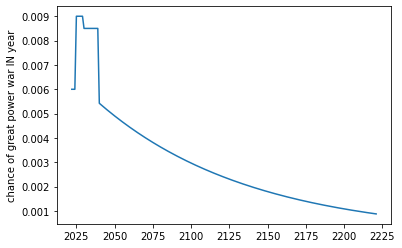

In [538]:
war_pdf = np.array([p_great_power_war(y) for y in years])
plt.plot(years, war_pdf)
plt.ylabel('chance of great power war IN year')


Text(0, 0.5, 'chance of great power war BY year')

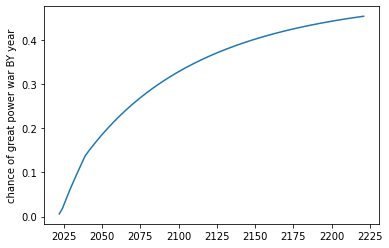

In [539]:
war_cdf = np.cumsum([war_pdf[0] if x == 0 else war_pdf[x] * np.prod(1 - war_pdf[:x]) for x in range(MAX_YEAR - CURRENT_YEAR)])
plt.plot(years, war_cdf)
plt.ylabel('chance of great power war BY year')


In [540]:
for y in years:
    print('Year: {} - chance of war IN year {}%, BY year {}%'.format(y,
                                                                     np.round(war_pdf[y - CURRENT_YEAR] * 100, 1),
                                                                     np.round(war_cdf[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - chance of war IN year 0.6%, BY year 0.6%
Year: 2023 - chance of war IN year 0.6%, BY year 1.2%
Year: 2024 - chance of war IN year 0.6%, BY year 1.8%
Year: 2025 - chance of war IN year 0.9%, BY year 2.7%
Year: 2026 - chance of war IN year 0.9%, BY year 3.5%
Year: 2027 - chance of war IN year 0.9%, BY year 4.4%
Year: 2028 - chance of war IN year 0.9%, BY year 5.3%
Year: 2029 - chance of war IN year 0.9%, BY year 6.1%
Year: 2030 - chance of war IN year 0.8%, BY year 6.9%
Year: 2031 - chance of war IN year 0.8%, BY year 7.7%
Year: 2032 - chance of war IN year 0.8%, BY year 8.5%
Year: 2033 - chance of war IN year 0.8%, BY year 9.3%
Year: 2034 - chance of war IN year 0.8%, BY year 10.1%
Year: 2035 - chance of war IN year 0.8%, BY year 10.8%
Year: 2036 - chance of war IN year 0.8%, BY year 11.6%
Year: 2037 - chance of war IN year 0.8%, BY year 12.3%
Year: 2038 - chance of war IN year 0.8%, BY year 13.1%
Year: 2039 - chance of war IN year 0.8%, BY year 13.8%
Year: 2040 - chance of

## Run Model

In [541]:
def p_tai_occurs_in(year):
    year = year - CURRENT_YEAR
    if year < 0:
        raise ValueError
    elif year == 0:
        return tai_pdf[0]
    else:
        return tai_pdf[year] / (1 - sum(tai_pdf[y] for y in range(year)))

def tai_available_in(year):
    return event_occurs(p_tai_occurs_in(year))

def aligned_tai_given_tai(year):
    return event_occurs(p_chance_alignment_solved(year))

collector_2022 = []
collector_2030 = []
collector_2050 = []
collector_2100 = []

results = []
print('Loaded')
print('-')

for r in range(RUNS):
    print('## RUN {}/{} ##'.format(r + 1, RUNS))
    terminate = False; terminate_y = None
    state = {'category': 'boring', 'tai': False, 'tai_type': None, 'nano': False, 'war': False}
    
    for y in years:
        if not terminate:
            print('Year {}'.format(y))
            
            ## TAI Scenarios
            if not terminate and (tai_available_in(y) or state['tai']):
                if (event_occurs(p_make_agent_tai) or state['tai_type'] == 'agent') and state['tai_type'] != 'tool':
                    # TODO: Do we want to re-roll the possibility of making agentic TAI in future years?
                    if aligned_tai_given_tai(y):
                        print('...Acheived aligned TAI, happy future! :D')
                        state['category'] = 'aligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                        terminate = True; terminate_y = y
                        # TODO: Does aligned TAI make xrisk impossible?
                    elif event_occurs(p_unaligned_tai_is_xrisk):
                        print('...XRISK from unaligned TAI :(')
                        state['category'] = 'xrisk_unaligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                        terminate = True; terminate_y = y
                    elif event_occurs(p_tai_intentional_misuse(state['war'])):
                        print('...XRISK from intentional misuse of TAI :(')
                        state['category'] = 'xrisk_tai_misuse'; state['tai'] = True; state['tai_type'] = 'agent'
                        terminate = True; terminate_y = y
                    else:
                        state['tai'] = True; state['tai_type'] = 'agent'
                        # TODO: These scenarios require more analysis
                else:
                    state['tai'] = True; state['tai_type'] = 'tool'
                    # TODO: Does tool AI help mitigate xrisk?
            # TODO: TAI or nearness to TAI creates great power war
            # TODO: Great power war lowers alignment chance
            
                                      
            ## Great power war scenarios
            if not terminate and (event_occurs(p_great_power_war(y)) and not state['war']):
                print('WAR!!!')
                state['war'] = True
                # TODO: Great power war can end

            
            ## Nuclear scenarios
            if not terminate and event_occurs(p_nuclear_accident(state['war'])):
                if event_occurs(p_nuclear_accident_becomes_exchange):
                    if event_occurs(p_xrisk_from_nuclear_exchange):
                        print('...XRISK from nukes (accidental exchange) :(')
                        state['category'] = 'xrisk_nukes_accident'
                        terminate = True; terminate_y = y

            if not terminate and state['war'] and event_occurs(p_nuclear_war_given_war):
                if event_occurs(p_xrisk_from_nuclear_exchange):
                    print('...XRISK from nukes (war) :(')
                    state['category'] = 'xrisk_nukes_war'
                    terminate = True; terminate_y = y
            
                                      
            ## Pathogen scenarios
            # TODO: Accidental pathogen scenarios
            if not terminate and state['war'] and event_occurs(p_biowar_given_war):
                if event_occurs(p_xrisk_from_bio):
                    print('...XRISK from pathogen (war) :(')
                    state['category'] = 'xrisk_pathogen_war'
                    terminate = True; terminate_y = y
            
            
            ## Nanotech scenarios
            if not terminate and event_occurs(p_nanotech_possible) and state != 'nanotech_available':
                state['nano'] = True
                if event_occurs(p_nanotech_is_xrisk):
                    print('...XRISK from nanotech :(')
                    state['category'] = 'xrisk_nanotech'
                    terminate = True; terminate_y = y
            
            
            ## "Unknown unknown" scenarios
            if not terminate and event_occurs(p_unknown_unknown_xrisk):
                print('...XRISK from unknown unknown')
                state['category'] = 'xrisk_unknown_unknown'
                terminate = True; terminate_y = y
    
    
        if y == 2022:
            collector_2022.append([copy(state), terminate_y])
        elif y == 2030:
            collector_2030.append([copy(state), terminate_y])
        elif y == 2050:
            collector_2050.append([copy(state), terminate_y])
        elif y == 2100:
            collector_2100.append([copy(state), terminate_y])
            
                    
    if not terminate:
        print('...Boring future')
        terminate_y = y
        
    results.append([state, terminate_y])

    print('-')
    print('-')

Loaded
-
## RUN 1/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
...XRISK from nukes (accidental exchange) :(
-
-
## RUN 2/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
...Acheived aligned TAI, happy future! :D
-
-
## RUN 3/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
...Acheived aligned TAI, happy future! :D
-
-

Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
...Acheived aligned TAI, happy future! :D
-
-
## RUN 22/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
...Acheived aligned TAI, happy future! :D
-
-
## RUN 23/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
WAR!!!
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 

Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
...Acheived aligned TAI, happy future! :D
-
-
## RUN 41/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
WAR!!!
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083

Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
...XRISK from unaligned TAI :(
-
-
## RUN 64/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
WAR!!!
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049


...XRISK from unaligned TAI :(
-
-
## RUN 89/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
...Acheived aligned TAI, happy future! :D
-
-
## RUN 90/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
...XRISK from unaligned TAI :(
-
-
## RUN 91/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070


Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154


Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196


Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171


Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174


Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 171/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
...Acheived aligned TAI, happy future! :D
-
-
## RUN 172/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
WAR!!!
Year 2042
...XRISK from unaligned TAI :(
-
-
## RUN 173/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year

Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203


Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
...XRISK from nukes (war) :(
-
-
## RUN 214/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
WAR!!!
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
...Acheived aligned TAI, happy future! :D
-
-
## RUN 215/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2

Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
...XRISK from unaligned TAI :(
-
-
## RUN 239/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
...Acheived aligned TAI, happy future! :D
-
-
## RUN 240/1000 ##
Year 2022
Year 2023
WAR!!!
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
...Acheived aligned TAI, happy future! :D
-
-
## RUN 241/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029

Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
...XRISK from intentional misuse of TAI :(
-
-
## RUN 259/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
...Acheived aligned TAI, happy future! :D
-
-
## RUN 260/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
...Acheived aligned TAI, happy future! :D
-
-
## RUN 261/10

Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
...XRISK from unaligned TAI :(
-
-
## RUN 286/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
WAR!!!
Year 2036
Year 2037
Year 2038

Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
...Acheived aligned TAI, happy future! :D
-
-
## RUN 310/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
...XRISK from unaligned TAI :(
-
-
## RUN 311/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
...Acheived aligned TAI, happy future! :D
-
-
## RUN 312/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2

...Acheived aligned TAI, happy future! :D
-
-
## RUN 333/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
WAR!!!
Year 2035
...XRISK from unaligned TAI :(
-
-
## RUN 334/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year

Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 358/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051


Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184


Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124


Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
...Acheived aligned TAI, happy future! :D
-
-
## RUN 422/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
...XRISK from unaligned TAI :(
-
-
## RUN 423/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Y

Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
...Acheived aligned TAI, happy future! :D
-
-
## R

Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
...Acheived aligned TAI, happy future! :D
-
-
## RUN 453/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
...Acheived aligned TAI, happy future! :D
-
-
## RUN 454/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033


WAR!!!
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
...Acheived aligned TAI, happy future! :D
-
-
## RUN 473/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
...Acheived aligned TAI, happy future! :D
-
-
## RUN 474/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
...Acheived aligned TAI, happy future! :D
-
-
## RUN 475/1000 ##
Year 202

Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163


Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
WAR!!!
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Yea

Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 553/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
...XRISK from unaligned TAI :(

-
## RUN 587/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119

Year 2061
Year 2062
Year 2063
Year 2064
WAR!!!
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Yea

Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
...XRISK from nukes (war) :(
-
-
## RUN 629/1000 ##
Year 2022
Year 2023
Year 2024
Year 202

Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
...Acheived aligned TAI, happy future! :D
-
-
## RUN 651/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
...XRISK from intentional misuse of TAI :(
-
-
## RUN 652/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
...Acheived aligned TAI, happy future! :D
-
-
## RUN 653/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
...Acheived aligned TAI, happy future! :D
-
-
## RUN 654/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032

Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214


-
## RUN 693/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119

Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
...Acheived aligned TAI, happy future! :D
-
-
## RUN 719/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
WAR!!!
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
...XRISK from unaligned TAI :(
-
-
## RUN 720/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year

Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 742/1000 ##
Year 2022
Year 2023


Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
WAR!!!
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
...Acheived aligned TAI, happy future! :D
-
-
## RUN 767/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 208

WAR!!!
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
...XRISK from intentional misuse of TAI :(
-
-
## RUN 789/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
WAR!!!
Year 2049
...XRISK from unaligned TAI :(
-
-
## RUN 790/1000 ##
Year 2022
Year 2023
Year 2024
WAR!!!
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
...Acheived aligned TAI, happy future! :D
-
-
## RUN 791/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year

Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 828/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031


Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
...XRISK from unknown unknown
-
-
## RUN 853/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
...XRISK from unaligned TAI :(
-
-
## RUN 854/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
...XRISK from intentional misuse of TAI :(
-
-
## RUN 855/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
...XRISK from unaligned TAI :(
-
-
## RUN 856/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Yea

Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
...Acheived aligned TAI, happy future! :D
-
-
## RUN 888/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
...Ac

Year 2057
Year 2058
Year 2059
Year 2060
...Acheived aligned TAI, happy future! :D
-
-
## RUN 910/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
WAR!!!
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
...Acheived aligned TAI, happy future! :D
-
-
## RUN 911/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
...XRISK from unaligned TAI :(
-
-
## RUN 912/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
...Acheived aligned TAI, happy future! :D
-
-
## RUN 913/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
...XRISK from unaligned TAI :(
-
-
## RUN 914/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032


Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210


Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 963/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028


Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
...XRISK from intentional misuse of TAI :(
-
-
## RUN 985/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
...Acheived aligned TAI, happy future! :D
-
-
## RUN 986/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043

In [542]:
print('## 2022 ##')
c = Counter([r[0]['category'] for r in collector_2022])
for i in c.items():
    print(i[0], '{}%'.format(np.round(i[1] / RUNS * 100, 1)))

## 2022 ##
boring 99.9%
xrisk_unknown_unknown 0.1%


In [543]:
print('## 2030 ##')
c = Counter([r[0]['category'] for r in collector_2030])
for i in c.items():
    print(i[0], '{}%'.format(np.round(i[1] / RUNS * 100, 1)))

## 2030 ##
xrisk_nukes_accident 0.1%
boring 92.0%
xrisk_unaligned_tai 2.8%
aligned_tai 2.9%
xrisk_nanotech 0.2%
xrisk_unknown_unknown 1.6%
xrisk_tai_misuse 0.4%


In [544]:
print('## 2050 ##')
c = Counter([r[0]['category'] for r in collector_2050])
for i in c.items():
    print(i[0], '{}%'.format(np.round(i[1] / RUNS * 100, 1)))

## 2050 ##
xrisk_nukes_accident 0.1%
boring 53.9%
aligned_tai 23.6%
xrisk_unaligned_tai 15.7%
xrisk_tai_misuse 3.6%
xrisk_unknown_unknown 2.7%
xrisk_nanotech 0.4%


In [545]:
print('## 2100 ##')
c = Counter([r[0]['category'] for r in collector_2100])
for i in c.items():
    print(i[0], '{}%'.format(np.round(i[1] / RUNS * 100, 1)))

## 2100 ##
xrisk_nukes_accident 0.2%
aligned_tai 43.1%
xrisk_unaligned_tai 23.1%
xrisk_unknown_unknown 3.9%
boring 22.3%
xrisk_tai_misuse 6.5%
xrisk_nanotech 0.7%
xrisk_nukes_war 0.2%


In [546]:
print("## {} (max) ##".format(MAX_YEAR))
c = Counter([r[0]['category'] for r in results])
for i in c.items():
    print(i[0], '{}%'.format(np.round(i[1] / RUNS * 100, 1)))

## 2222 (max) ##
xrisk_nukes_accident 0.5%
aligned_tai 46.6%
xrisk_unaligned_tai 24.2%
xrisk_unknown_unknown 5.9%
boring 13.5%
xrisk_tai_misuse 6.6%
xrisk_nukes_war 1.3%
xrisk_nanotech 1.3%
xrisk_pathogen_war 0.1%


In [547]:
sum([r[0]['war'] for r in collector_2100]) / len(collector_2100)

0.179